In [9]:
%load_ext autoreload
%autoreload 2


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from ml_logic.preprocessor import data_balancing, create_model, load_and_preprocess_image, image_augmentation
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Model, Sequential, layers, models


2023-12-05 19:14:40.679239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 19:14:43.435649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-05 19:14:43.435745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-05 19:14:43.749999: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 19:14:51.916967: W tensorflow/stream_executor/platform/de

In [10]:
# Loading Datasets

train = pd.read_csv('../data/RFMiD_Training_Labels.csv').set_index('ID')
test = pd.read_csv('../data/RFMiD_Testing_Labels.csv').set_index('ID')
eval = pd.read_csv('../data/RFMiD_Validation_Labels.csv').set_index('ID')


In [11]:
# Splitting Data

# X_train = train.drop(columns='Disease_Risk')
X_train = data_balancing(table_link='../data/')
# y_train = train['Disease_Risk']
y_train = X_train
X_eval  = eval.drop(columns='Disease_Risk')
y_eval = eval['Disease_Risk']


In [12]:
print(X_train.sample(5))
print(X_train.shape)
print(y_train.sample(5))
print(y_train.shape)


      Disease_Risk
ID                
1801             0
1752             0
396              1
26               1
179              0
(802, 1)
      Disease_Risk
ID                
1761             1
593              0
1445             1
77               1
1303             0
(802, 1)


In [13]:
# Loading Images

image_folder = '../data/training_images'
eval_image_folder = '../data/eval_images'
images = np.array([load_and_preprocess_image(row_id, image_folder) for row_id in X_train.index])
eval_images = np.array([load_and_preprocess_image(row_id, eval_image_folder) for row_id in X_eval.index])


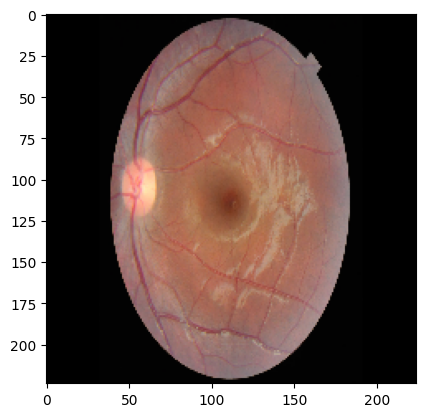

In [14]:
plt.imshow(images[0])


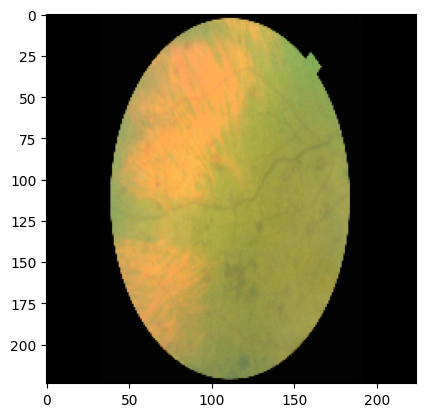

In [15]:
plt.imshow(eval_images[0])


In [16]:
# Augment Images

augmented_images = image_augmentation(images)
augmented_eval_images = image_augmentation(eval_images)


2023-12-05 20:48:47.159280: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [17]:
print(augmented_images.shape)
print(augmented_eval_images.shape)


(802, 224, 224, 3)
(640, 224, 224, 3)


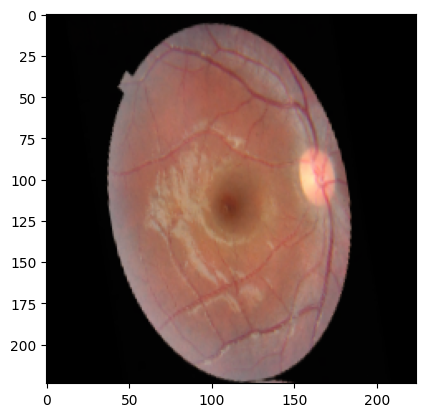

In [18]:
plt.imshow(augmented_images[0])


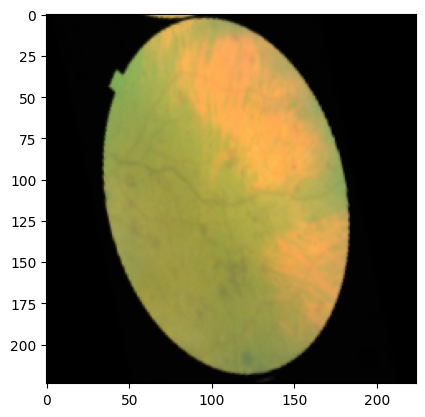

In [19]:
plt.imshow(augmented_eval_images[0])


In [20]:
##### DATA AUGMENTATION CODE FROM CNN RECAP#####
# data_augmentation = models.Sequential()

# data_augmentation.add(layers.RandomFlip("horizontal"))
# data_augmentation.add(layers.RandomZoom(0.1))
# data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
# data_augmentation.add(layers.RandomRotation(0.1))


In [21]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))


58889256/58889256 [==============================] - 2s 0us/step


In [22]:
#model = create_model((224,224,3)) ##first model


####test with VGG model addition####
image_input = layers.Input(shape=(224, 224, 3))
#x = data_augmentation(image_input) # We still have our data augmentation layers
x = preprocess_input(image_input) # Then a preprocessing layer specifically designed for the VGG16
x = base_model(x) # Then our transfer learning model
# x = Conv2D(32, (3, 3), activation='relu')(x)
# x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

z = Dense(12, activation='relu')(x)
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)

model_test = Model(inputs=image_input, outputs=z)
# And we freeze the VGG16 model
base_model.trainable = False


In [23]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 774400)            0         
                                                                 
 dense_3 (Dense)             (None, 12)                9292812   
                                                           

In [24]:
model_test.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 12)                301068    
                                                             

In [25]:
early_stopper = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.05,
    patience=10,
)


In [ ]:
# model.fit(
#     augmented_images, y_train,
#     validation_data=(augmented_eval_images, y_eval),
#     epochs=20,
#     batch_size=64,
#     callbacks=[early_stopper]
# )


Epoch 1/20
13/13 [==============================] - 48s 4s/step - loss: 0.8441 - accuracy: 0.5087 - val_loss: 0.6625 - val_accuracy: 0.7906
Epoch 2/20
13/13 [==============================] - 48s 4s/step - loss: 0.6871 - accuracy: 0.4900 - val_loss: 0.6860 - val_accuracy: 0.4156
Epoch 3/20
13/13 [==============================] - 49s 4s/step - loss: 0.6804 - accuracy: 0.5661 - val_loss: 0.6663 - val_accuracy: 0.5141
Epoch 4/20
13/13 [==============================] - 47s 4s/step - loss: 0.6495 - accuracy: 0.6496 - val_loss: 0.5682 - val_accuracy: 0.7125
Epoch 5/20
13/13 [==============================] - 48s 4s/step - loss: 0.6369 - accuracy: 0.6409 - val_loss: 0.5740 - val_accuracy: 0.6062
Epoch 6/20
13/13 [==============================] - 48s 4s/step - loss: 0.6179 - accuracy: 0.6671 - val_loss: 0.5899 - val_accuracy: 0.5500
Epoch 7/20
13/13 [==============================] - 61s 5s/step - loss: 0.6445 - accuracy: 0.6147 - val_loss: 0.6131 - val_accuracy: 0.4750
Epoch 8/20
13/13 [==

In [26]:
history = model_test.fit(
    augmented_images, y_train,
    validation_data=(augmented_eval_images, y_eval),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopper]
)


Epoch 1/20
13/13 [==============================] - 162s 13s/step - loss: 0.7080 - accuracy: 0.5050 - val_loss: 0.7299 - val_accuracy: 0.2094
Epoch 2/20
13/13 [==============================] - 155s 12s/step - loss: 0.6959 - accuracy: 0.5075 - val_loss: 0.8132 - val_accuracy: 0.2094
Epoch 3/20


KeyboardInterrupt: 

In [ ]:
#model.evaluate(augmented_eval_images, y_eval)


20/20 [==============================] - 7s 338ms/step - loss: 0.6433 - accuracy: 0.4766


[0.643252968788147, 0.4765625]

In [ ]:
model_test.evalutate(augmented_eval_images, y_eval)
